# <div align="center">The Single Project Budgetting Agent<div/>
    
<br/><br/>
**as an introductory educational practice for the ultimate goal of developing and training the complex agent for optimizing the budgeting of the portfolio, I'll start by developing the single project agent**

<br/><br>

---

## <div align="center">Importing the modules<div/>

In [1]:
# cell 1: imports and basic config
import math
import os
import pandas as pd

from datetime import datetime

import numpy as np
import gymnasium as gym
from gymnasium import spaces

# For stable-baselines3 later
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback

import tensorflow as tf
import matplotlib.pyplot as plt


---
## <div align="center">Designing environment<div/>

In [2]:
# cell 2: the custom environment class (Gymnasium API)
class SingleProjectBudgetEnv(gym.Env):
    """
    Single Project Budget Allocation environment (Gymnasium API).

    Observation:
        Type: Box(3)
        [remaining_budget_frac, timesteps_left_frac, cumulative_spent_frac]
        All in [0,1]

    Actions:
        Type: Discrete(4) -> map to fractions of *remaining budget*:
            0 -> 0.0
            1 -> 0.25
            2 -> 0.5
            3 -> 1.0

    Rewards:
        +1 for progress (allocated > 0 and not overspend)
        -10 for overspend (defensive)
        +100 for completion (cumulative_spent >= completion_threshold)
    """
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self,
                 total_budget: float = 100.0,
                 max_timesteps: int = 10,
                 completion_threshold: float = 90.0,
                 render_mode: str | None = None):
        super().__init__()

        self.total_budget = float(total_budget)
        self.max_timesteps = int(max_timesteps)
        self.completion_threshold = float(completion_threshold)

        # Action mapping (fractions of remaining budget)
        self.action_map = [0.0, 0.25, 0.5, 1.0]

        # Define action & observation spaces
        self.action_space = spaces.Discrete(len(self.action_map))
        # obs: remaining_frac, timesteps_left_frac, cumulative_spent_frac
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # internal state
        self.current_step = None
        self.remaining_budget = None
        self.cumulative_spent = None
        self.done = None
        self.render_mode = render_mode

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        # Gymnasium seeding pattern
        super().reset(seed=seed)
        self.current_step = 0
        self.remaining_budget = float(self.total_budget)
        self.cumulative_spent = 0.0
        self.done = False

        obs = self._get_obs()
        info = {}
        return obs, info

    def _get_obs(self):
        return np.array([
            self.remaining_budget / self.total_budget,
            (self.max_timesteps - self.current_step) / max(1, self.max_timesteps),
            self.cumulative_spent / self.total_budget
        ], dtype=np.float32)

    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action: {action}"
        frac = self.action_map[int(action)]
        allocated = frac * self.remaining_budget  # allocation is fraction of *current remaining* budget

        reward = 0.0
        info = {}

        # Overspend defensive check (shouldn't happen with our action map)
        if allocated > self.remaining_budget + 1e-8:
            # overspend
            reward += -10.0
            self.done = True
            terminated = True
            truncated = False
            obs = self._get_obs()
            return obs, reward, terminated, truncated, info

        # Apply allocation
        self.remaining_budget -= allocated
        self.cumulative_spent += allocated

        # Progress reward: +1 for making progress this step (allocated > 0)
        if allocated > 0:
            reward += 1.0

        # Completion check
        if self.cumulative_spent >= self.completion_threshold:
            reward += 100.0
            self.done = True
            terminated = True
            truncated = False
            obs = self._get_obs()
            return obs, reward, terminated, truncated, info

        # Step advancement
        self.current_step += 1
        # If reached max timesteps -> truncated episode
        if self.current_step >= self.max_timesteps:
            self.done = True
            terminated = False
            truncated = True
        else:
            terminated = False
            truncated = False

        obs = self._get_obs()
        return obs, reward, terminated, truncated, info

    def render(self):
        if self.render_mode == "human":
            print(f"Step {self.current_step}: remaining={self.remaining_budget:.2f}, "
                  f"spent={self.cumulative_spent:.2f}")
        else:
            return None

    def close(self):
        pass


---
## <div align="center">sanity check<div/>

In [3]:
# cell: sanity check
env = SingleProjectBudgetEnv(total_budget=100, max_timesteps=10, completion_threshold=90.0, render_mode="human")
obs, info = env.reset()
print("Initial obs:", obs)
# try a greedy policy: always 25% of remaining
for _ in range(5):
    obs, r, term, trunc, info = env.step(1)  # action 1 -> 25%
    env.render()
    print("reward", r, "term", term, "trunc", trunc)
    if term or trunc:
        break

Initial obs: [1. 1. 0.]
Step 1: remaining=75.00, spent=25.00
reward 1.0 term False trunc False
Step 2: remaining=56.25, spent=43.75
reward 1.0 term False trunc False
Step 3: remaining=42.19, spent=57.81
reward 1.0 term False trunc False
Step 4: remaining=31.64, spent=68.36
reward 1.0 term False trunc False
Step 5: remaining=23.73, spent=76.27
reward 1.0 term False trunc False


---
## <div align="center">vectorized & normalized envs and model<div/>

In [4]:
# cell: create vectorized & normalized envs and model
log_dir = "./logs_sb3/"
os.makedirs(log_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join("logs_sb3", f"ran_at_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

def make_env(rank=0):
    def _init():
        env = SingleProjectBudgetEnv(total_budget=100, max_timesteps=10, completion_threshold=90.0)
        # Monitor writes episode info to csv for analysis if filename provided
        monitor_file = os.path.join(run_dir, f"env_{rank}")
        
        return Monitor(env, filename=monitor_file)
    return _init

n_envs = 4
venv = DummyVecEnv([make_env(i) for i in range(n_envs)])
# Normalize observations (not rewards here). Stable Baselines3 has VecNormalize.
venv = VecNormalize(venv, norm_obs=True, norm_reward=False)

---
## <div align="center">model<div/>

In [5]:
# cell: create model
model = PPO(
    policy="MlpPolicy",
    env=venv,
    verbose=1,
    tensorboard_log="./tb_logs/",
    learning_rate=3e-4,
    n_steps=2048,     # amount of experience per environment per update
    batch_size=64,
    ent_coef=0.0,
    clip_range=0.2    # important PPO hyperparameter (explained below)
)

Using cpu device


---
## <div align="center">Training<div/>

In [6]:
# cell: train
total_timesteps = 50_000  # small for a toy env; increase to 200k+ for sturdier learning
model.learn(total_timesteps=total_timesteps)
# save model
model.save("ppo_budget_agent")

Logging to ./tb_logs/PPO_14
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.13     |
|    ep_rew_mean     | 101      |
| time/              |          |
|    fps             | 2417     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.54        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 1292        |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.035939004 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | -0.00163    |
| 

---
## <div align="center">Visualization<div/>

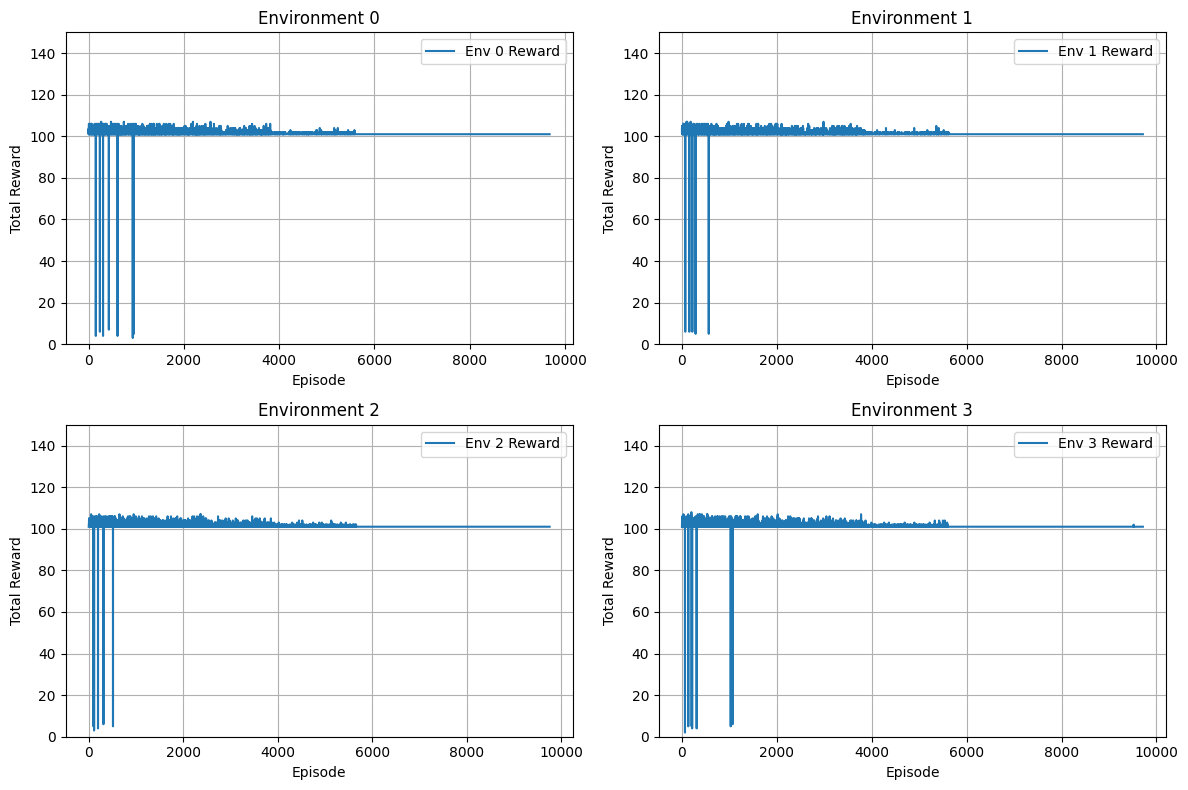

In [16]:
# Clean the CSV Before Reading

# import re

# def clean_monitor_csv(input_path, output_path):
#     lines = []
#     with open(input_path, "r") as f:
#         for line in f:
#             # Skip the header and metadata line
#             if line.startswith("#") or line.strip() == "":
#                 continue

#             # Extract only valid reward,length,time triples
#             match = re.findall(r"(\d+\.?\d*),(\d+),(\d+\.\d+)", line)
#             for r, l, t in match:
#                 lines.append(f"{r},{l},{t}\n")

#     # Write clean data
#     with open(output_path, "w") as f:
#         f.write("r,l,t\n")
#         f.writelines(lines)

#     print(f"✅ Cleaned data written to {output_path}, {len(lines)} valid entries found.")

# clean_monitor_csv("./logs_sb3/run_20251011_144601/monitor_0.csv", "./logs_sb3/run_20251011_144601/monitor_0_clean.csv")



# Directory containing monitor CSVs
ran_at="ran_at_20251011_154322"
log_dir = f"./logs_sb3/{ran_at}/"

# Create figure with 2 rows x 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # flatten to index easily

for i in range(n_envs):
    # Construct file path
    file_path = os.path.join(log_dir, f"env_{i}.monitor.csv")
    
    # Read CSV, skip first line (metadata)
    df = pd.read_csv(file_path, skiprows=1)
    
    # Plot episode rewards
    axes[i].plot(df["r"], label=f"Env {i} Reward")
    axes[i].set_xlabel("Episode")
    axes[i].set_ylabel("Total Reward")
    axes[i].set_title(f"Environment {i}")
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_ylim(0, 150)  # match your previous axis

plt.tight_layout()
plt.show()


In [23]:
# the command for tensorboard: tensorboard --logdir ./tb_logs

%load_ext tensorboard 
%tensorboard --logdir ./tb_logs/PPO_14

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
